,buydates,selldates,buyprices,sellprices,profit_rel,net_profit
0,2022-12-05 09:00:00,2022-12-05 09:00:00,1301.65,1301.65,0.0,0.0
1,2022-12-07 00:00:00,2022-12-07 00:00:00,1271.31,1271.31,0.0,0.0
2,2022-12-08 12:00:00,2022-12-08 14:00:00,1240.4,1244.69,0.003459,4.29
3,2022-12-08 18:00:00,2022-12-08 18:00:00,1254.53,1254.53,0.0,0.0
4,2022-12-10 15:00:00,2022-12-10 15:00:00,1271.7,1271.7,0.0,0.0
5,2022-12-11 08:00:00,2022-12-11 08:00:00,1276.49,1276.49,0.0,0.0
6,2022-12-11 19:00:00,2022-12-11 19:00:00,1279.48,1279.48,0.0,0.0
7,2022-12-12 21:00:00,2022-12-12 21:00:00,1266.68,1266.68,0.0,0.0
8,2022-12-13 00:00:00,2022-12-13 00:00:00,1275.41,1275.41,0.0,0.0
9,2022-12-13 10:00:00,2022-12-13 12:00:00,1278.05,1286.92,0.00694,8.87


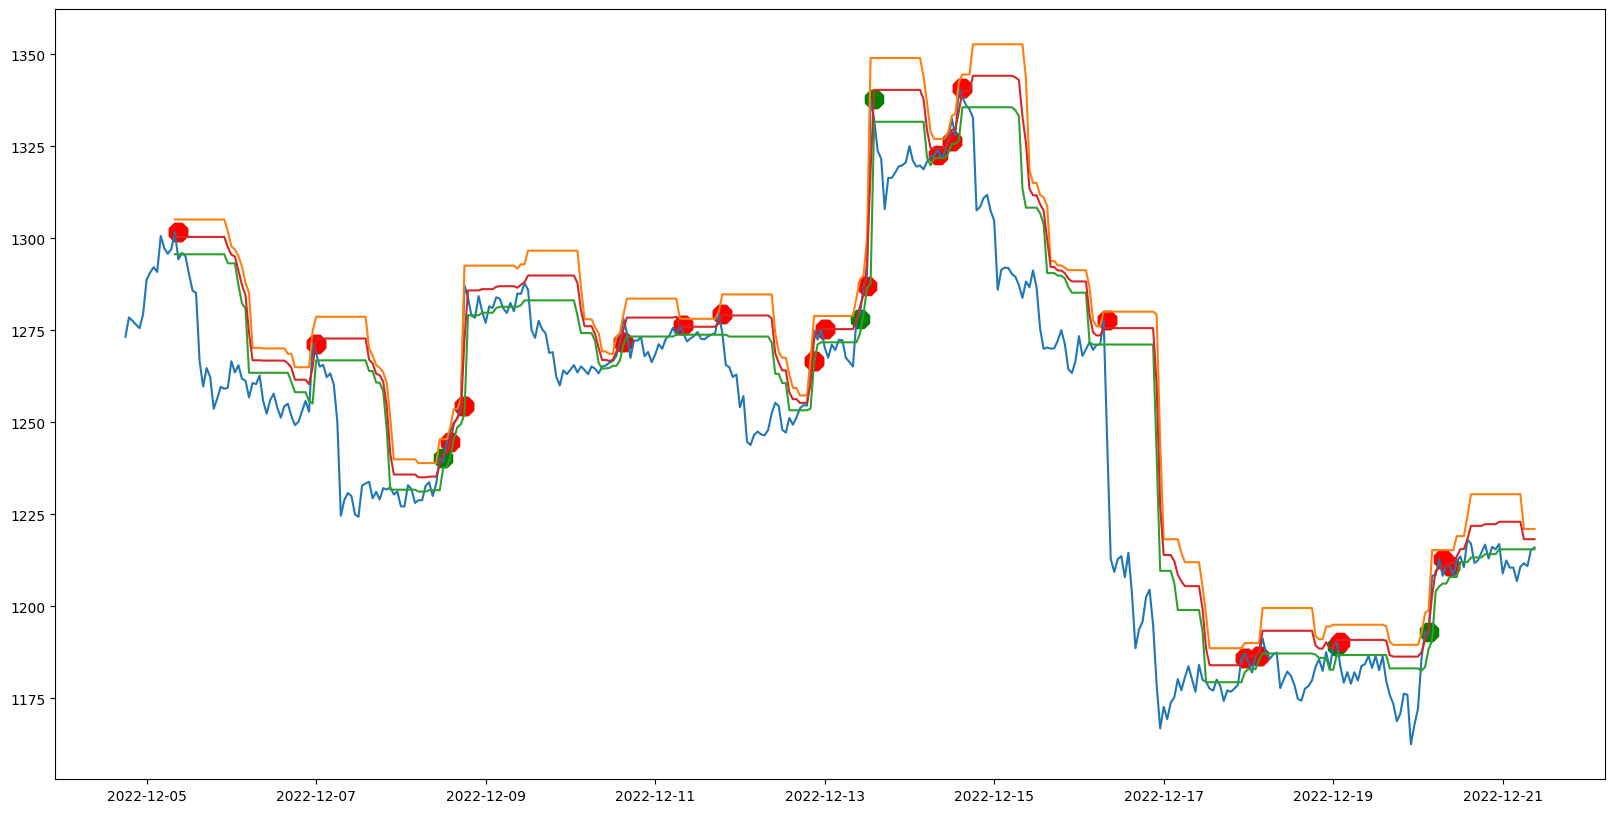

In [2]:
import pandas as  pd 
import numpy as np
from binance import Client
import matplotlib.pyplot as plt
client = Client()

def getdata(symbol, interval='1h', lookback='400'):
    frame = pd.DataFrame(client.get_historical_klines(symbol,
                                                     interval,
                                                    lookback+' hours UTC'))

    frame = frame.iloc[:,0:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame.set_index('Time', inplace=True)
    frame.index = pd.to_datetime(frame.index, unit='ms')
    frame = frame.astype(float)
    return frame

df = getdata('ETHUSDT')

df['rollhigh'] = df.High.rolling(15).max()
df['rolllow'] = df.Low.rolling(15).max()
df['mid'] = (df.rollhigh + df.rolllow)/2
df['highapproach'] = np.where(df.Close > df.rollhigh * 0.996, 1, 0)
df['close_a_mid'] = np.where(df.Close > df.mid, 1, 0)
df['midcross'] = df.close_a_mid.diff() == 1 

in_position = False
buydates,selldates = [], []

for i in range(len(df)):
    if not in_position:
        if df.iloc[i].midcross:
            buydates.append(df.iloc[i+1].name)
            in_position = True

    if in_position:
        if df.iloc[i].highapproach:
            selldates.append(df.iloc[i+1].name)
            in_position = False

plt.figure(figsize=(20,10))
plt.plot(df[['Close', 'rollhigh', 'rolllow', 'mid']])
plt.scatter(buydates, df.loc[buydates].Open, marker='8', color='g', s=200)
plt.scatter(selldates, df.loc[selldates].Open, marker='8', color='r', s=200)

tradesdf = pd.DataFrame( [buydates,selldates,df.loc[buydates].Open, df.loc[selldates].Open]).T
tradesdf.columns = ['buydates', 'selldates', 'buyprices', 'sellprices']
tradesdf.dropna(inplace=True)
tradesdf['profit_rel'] = (tradesdf.sellprices - tradesdf.buyprices)/tradesdf.buyprices
tradesdf['net_profit'] = tradesdf.sellprices - tradesdf.buyprices
total_net_profit = tradesdf['net_profit'].sum()

tradesdf